In [1]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_800x800_20x20_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 51  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)

../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [6]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [7]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [20]:
# In[12]:
in_data = {}
for file_idx in trange(1,51):
    fname = IN_DATA_FNAMES[file_idx-1]
    f = open(fname, 'rb') 
    c_in_data = pickle.load(f) 
    f.close()
    for key in c_in_data:
        if(key not in in_data.keys()):
            in_data[key] = np.array(c_in_data[key])
        else:
            in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


for key in in_data:
    print(key, np.shape(in_data[key]))

100%|██████████| 50/50 [03:14<00:00,  3.89s/it]

cmb0F_1 (500, 800, 401)
kCmbF_1 (500, 800, 401)
lCmbF_1 (500, 800, 401)
fgF_1 (500, 800, 401)
noiseF_1 (500, 800, 401)
totalF_1 (500, 800, 401)
totalF_0 (500, 800, 401)


In [21]:
ps_data = {}


#estimate GRF Nhat
ck = 'GRF'
for data_idx in trange(500):
    curr_data = in_data['totalF_0'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=curr_data, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

100%|██████████| 500/500 [00:08<00:00, 60.59it/s]


In [41]:
L, ClExpected= baseMap.binTheoryPowerSpectrum(ftot, nBins=nBins)

In [69]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    sCls = np.std(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/np.sqrt(n_runs)
    return lCen, Cls, sCls

500 (500, 3, 50)


Text(0.5, 0, '$L$')

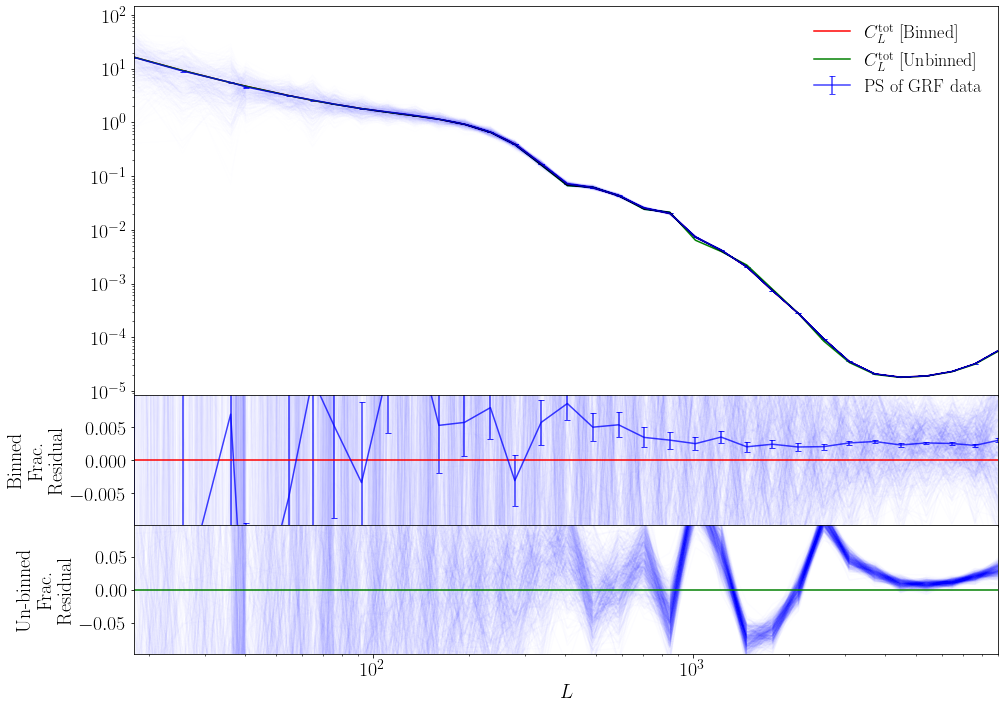

In [102]:
ps_data['GRF'].shape
fig = plt.figure(figsize=(16,9))
axs=[fig.add_axes((0.2,0.2,.75,.6)), fig.add_axes((0.2,0.0,.75,.2)),  fig.add_axes((0.2,-0.2,.75,.2))]
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 20



    
lCen, Cl, sCl = combine_Cl(ps_data['GRF'])
Ipos = np.where(Cl>0)
axs[0].errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt='-', capsize=3, capthick=1, label='PS of GRF data', c='blue')

assert((lCen[Ipos] == L[Ipos]).all())

axs[1].errorbar(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], yerr=sCl[Ipos]/ClExpected[Ipos], alpha=.75, 
                fmt='-', capsize=3, capthick=1, label='GRF data', c='blue')


theoryIpos = np.where(ClExpected > 0)
axs[0].plot(L[theoryIpos], ClExpected[theoryIpos], 'red', label=r'$C_L^{\rm tot}$ [Binned]')    


unbinnedCl = np.array(list(map(ftot, L)))
axs[0].plot(L[theoryIpos], unbinnedCl[theoryIpos], 'green', label=r'$C_L^{\rm tot}$ [Unbinned]')    

for lCen, Cl, sCl in ps_data['GRF']:
    Ipos = np.where(Cl>0)
    axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=0.005, color='blue')
    assert((lCen[Ipos] == L[Ipos]).all())
    axs[1].plot(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], alpha=0.01, color='blue')
    axs[2].plot(lCen[Ipos], (Cl[Ipos] - unbinnedCl[Ipos])/unbinnedCl[Ipos], alpha=0.01, color='blue')

# axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=1, color='blue', label='GRFs')

axs[0].legend(frameon=False)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
axs[1].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
axs[2].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])

axs[1].set_xscale('log')
# axs[1].set_yscale('log')

# axs[1].fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.85')#, label=r'$<1\%$ Error')

axs[1].axhline(0, c='red')

axs[1].set_ylim(-.98e-2, .98e-2)




axs[2].set_xscale('log')
axs[2].axhline(0, c='green')
axs[2].set_ylim(-.98e-1, .98e-1)

axs[1].set_ylabel('Binned \nFrac. \nResidual')
axs[2].set_ylabel('Un-binned \nFrac. \nResidual')
axs[2].set_xlabel(r'$L$')


In [78]:
# UH OH !!!!

In [101]:
np.random.seed(0)
totalCmbFourier = baseMap.genGRF(ftot)
totalCmb = baseMap.inverseFourier(totalCmbFourier)


In [103]:
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np

def process_data(i):
    np.random.seed(i)
    totalCmbFourier = baseMap.genGRF(ftot)
    totalCmb = baseMap.inverseFourier(totalCmbFourier)
    return totalCmbFourier

with Pool() as p:
    res = list(tqdm(p.imap(process_data, range(32)), total=32))
c_data_new = np.array(res)

 56%|█████▋    | 18/32 [23:22<18:10, 77.89s/it]  Process ForkPoolWorker-160:
Process ForkPoolWorker-170:

Process ForkPoolWorker-189:
Process ForkPoolWorker-182:
Process ForkPoolWorker-150:
Process ForkPoolWorker-164:
Process ForkPoolWorker-185:
Process ForkPoolWorker-172:
Process ForkPoolWorker-159:
Process ForkPoolWorker-188:
Process ForkPoolWorker-187:
Process ForkPoolWorker-165:
Process ForkPoolWorker-162:
Process ForkPoolWorker-155:
Process ForkPoolWorker-154:
Process ForkPoolWorker-151:


KeyboardInterrupt: 

Process ForkPoolWorker-167:
Process ForkPoolWorker-156:
Process ForkPoolWorker-152:
Process ForkPoolWorker-183:
Process ForkPoolWorker-186:
Process ForkPoolWorker-169:
Process ForkPoolWorker-173:
Process ForkPoolWorker-158:
Process ForkPoolWorker-157:
Process ForkPoolWorker-166:
Process ForkPoolWorker-161:
Process ForkPoolWorker-171:
Process ForkPoolWorker-163:
Process ForkPoolWorker-153:
Process ForkPoolWorker-184:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [ ]:
ck = 'GRF_new'
for data_idx in trange(500):
    curr_data = c_data_new[data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=curr_data, nBins=nBins)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

In [106]:
# fig = plt.figure(figsize=(16,9))
# axs=[fig.add_axes((0.2,0.2,.75,.6)), fig.add_axes((0.2,0.0,.75,.2)),  fig.add_axes((0.2,-0.2,.75,.2))]
# plt.rcParams['text.usetex'] = True

# plt.rcParams['font.size'] = 20



    
# lCen, Cl, sCl = combine_Cl(ps_data['GRF_new'])
# Ipos = np.where(Cl>0)
# axs[0].errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
#                 fmt='-', capsize=3, capthick=1, label='GRF data', c='blue')

# assert((lCen[Ipos] == L[Ipos]).all())

# axs[1].errorbar(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], yerr=sCl[Ipos]/ClExpected[Ipos], alpha=.75, 
#                 fmt='-', capsize=3, capthick=1, label='GRF data', c='blue')


# theoryIpos = np.where(ClExpected > 0)
# axs[0].plot(L[theoryIpos], ClExpected[theoryIpos], 'red', label=r'$C_L^{\rm tot}$ [Binned]')    


# unbinnedCl = np.array(list(map(ftot, L)))
# axs[0].plot(L[theoryIpos], unbinnedCl[theoryIpos], 'green', label=r'$C_L^{\rm tot}$ [Unbinned]')    

# for lCen, Cl, sCl in ps_data['GRF_new']:
#     Ipos = np.where(Cl>0)
#     axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=0.005, color='blue')
#     assert((lCen[Ipos] == L[Ipos]).all())
#     axs[1].plot(lCen[Ipos], (Cl[Ipos] - ClExpected[Ipos])/ClExpected[Ipos], alpha=0.01, color='blue')
#     axs[2].plot(lCen[Ipos], (Cl[Ipos] - unbinnedCl[Ipos])/unbinnedCl[Ipos], alpha=0.01, color='blue')

# # axs[0].plot(lCen[Ipos], Cl[Ipos], alpha=1, color='blue', label='GRFs')

# axs[0].legend(frameon=False)
# axs[0].set_xscale('log')
# axs[0].set_yscale('log')
# axs[0].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
# axs[1].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])
# axs[2].set_xlim(lCen[Ipos][0], lCen[Ipos][-1])

# axs[1].set_xscale('log')
# # axs[1].set_yscale('log')

# # axs[1].fill_between([0, 1e20], [-0.001, -0.001], [0.001, 0.001], alpha=1, color='0.85')#, label=r'$<1\%$ Error')

# axs[1].axhline(0, c='red')


# axs[1].set_ylim(-.98e-2, .98e-2)




# axs[2].set_xscale('log')
# axs[2].axhline(0, c='green')
# axs[2].set_ylim(-.98e-1, .98e-1)

# axs[1].set_ylabel('Binned \nFrac. \nResidual')
# axs[2].set_ylabel('Un-binned \nFrac. \nResidual')
# axs[2].set_xlabel(r'$L$')
